In [1]:
# Init spark session to read data from parquet files
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType, IntegerType
from pyspark.sql import functions as F
from stocksx.configs.spark_config import SparkConfig
from stocksx.data_pipeline.sub_modules.spark_manager import SparkManager
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F

spark_config = SparkConfig(iceberg_enabled=True, iceberg_namespace = "raw_data", 
                           iceberg_warehouse="data/warehouse/iceberg")
spark_manager = SparkManager(spark_config)
spark_manager.verify_configuration()
spark = spark_manager.session


=== Verifying Configuration ===
Testing Spark basic functionality...
Using package root: e:\projects\stocksx_price_and_news_influences
Iceberg warehouse: file:///e:/projects/stocksx_price_and_news_influences/data/warehouse/iceberg
Hive warehouse: file:///e:/projects/stocksx_price_and_news_influences/data/warehouse/hive
Found PostgreSQL JDBC driver at: e:\projects\stocksx_price_and_news_influences\stocksx\libs\postgresql-42.7.5.jar
Created Spark session with:
- Iceberg enabled: True
- Hive metastore: True
- Warehouse dir: file:///e:/projects/stocksx_price_and_news_influences/data/warehouse/iceberg
- Hive config dir: e:\projects\stocksx_price_and_news_influences\stocksx\configs
Basic Spark functionality: OK (1+1=2)

Initializing Hive metastore schema...
Initializing Hive metastore schema...
Hive metastore schema already exists.

Testing Iceberg functionality...
Iceberg functionality: OK

Testing Hive metastore...
Database result schema:
root
 |-- namespace: string (nullable = false)

Fo

In [3]:
# List all available catalogs
spark.sql("SHOW CATALOGS").show()

# List all namespaces in the local catalog
spark.sql("SHOW NAMESPACES IN spark_catalog").show()

+-------------+
|      catalog|
+-------------+
|spark_catalog|
+-------------+

+---------+
|namespace|
+---------+
|  default|
| raw_data|
+---------+



In [4]:
# Load data from the local Iceberg warehouse
# Using the catalog.database.table format
spark_df = spark.read.format("iceberg").table("spark_catalog.raw_data.stock_prices")


In [5]:
# Sanity check for a few symbols in the iceberg table

from pyspark.sql.functions import col
from pyspark.sql.functions import min, max, avg, count

symbols_to_check = ["AAPL", "MSFT", "GOOGL", "TSLA", "NVDA"]


# Filter for specific symbols
sample_df = spark_df.filter(col("symbol").isin(symbols_to_check))

# Display basic info about the data
print(f"Total records for symbols {symbols_to_check}: {sample_df.count()}")

# Check for missing values in important columns
print("\nMissing values in key columns:")
for column in sample_df.columns:
    null_count = sample_df.filter(col(column).isNull()).count()
    if null_count > 0:
        print(f"- {column}: {null_count} nulls")

# Show sample data for each symbol
print("\nSample data for each symbol:")
for symbol in symbols_to_check:
    print(f"\n--- {symbol} ---")
    sample_df.filter(col("symbol") == symbol).show(5, truncate=False)

if "close" in sample_df.columns:
    print("\nclose Price statistics by symbol:")
    sample_df.groupBy("symbol").agg(
        min("close").alias("min_close"),
        max("close").alias("max_close"),
        avg("close").alias("avg_close"),
        count("close").alias("close_count")
    ).show()

Total records for symbols ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']: 36431

Missing values in key columns:

Sample data for each symbol:

--- AAPL ---
+------+----------+-----------------+-----------------+------------------+-----------------+---------+
|symbol|trade_date|open             |high             |low               |close            |volume   |
+------+----------+-----------------+-----------------+------------------+-----------------+---------+
|AAPL  |2010-01-04|6.422877311706543|6.455077171325684|6.3912787437438965|6.44033145904541 |493729600|
|AAPL  |2010-01-05|6.458086967468262|6.487879276275635|6.417459964752197 |6.451466083526611|601904800|
|AAPL  |2010-01-06|6.451465129852295|6.477044582366943|6.342225074768066 |6.348845958709717|552160000|
|AAPL  |2010-01-07|6.372318744659424|6.379842281341553|6.291065692901611 |6.337108612060547|477131200|
|AAPL  |2010-01-08|6.328685760498047|6.379845142364502|6.291370391845703 |6.379242897033691|447610800|
+------+----------+------

In [6]:
# Convert Spark DataFrame to Pandas DataFrame
sample_pd = sample_df.toPandas()

# Take only data from 2007 onwards
sample_pd = sample_pd[sample_pd["trade_date"] >= pd.to_datetime("2014-01-01")]

d:\Tools\anaconda3\envs\tf270_stocks\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


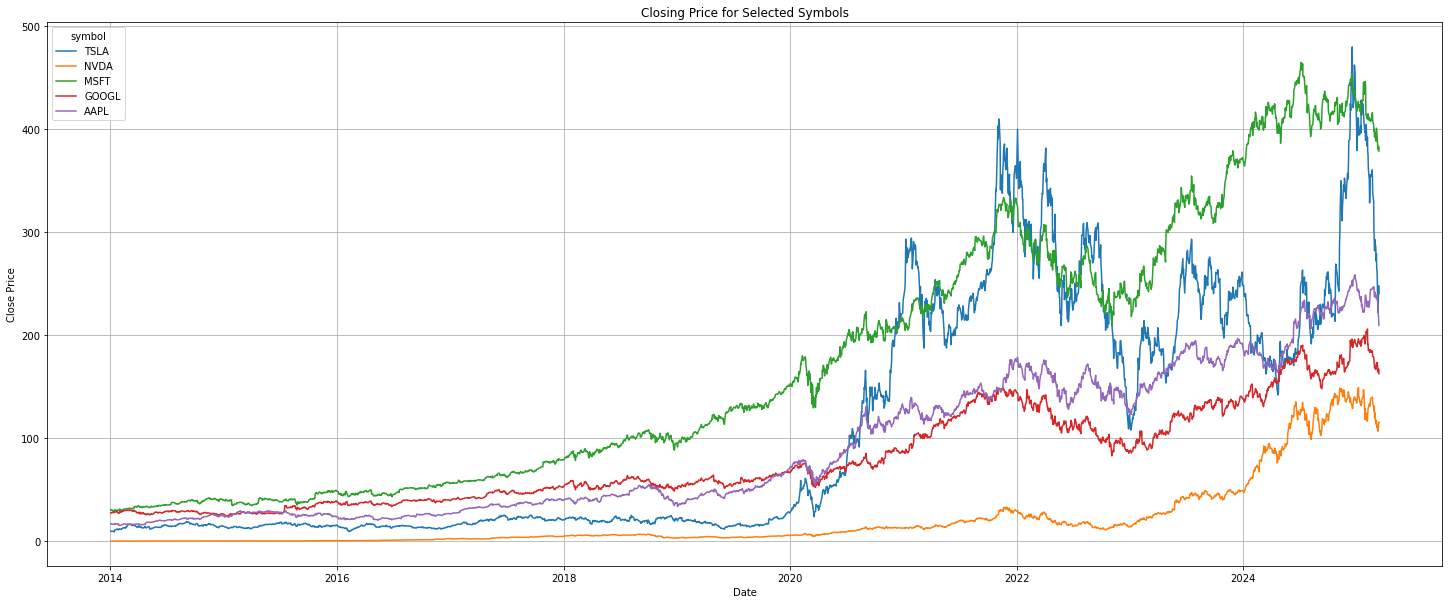

In [7]:
# plot a line chart for the closing price of the symbols

# Plot the closing price for each symbol
plt.figure(figsize=(25, 10))
sns.lineplot(data=sample_pd, x="trade_date", y="close", hue="symbol")
plt.title("Closing Price for Selected Symbols")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.show()



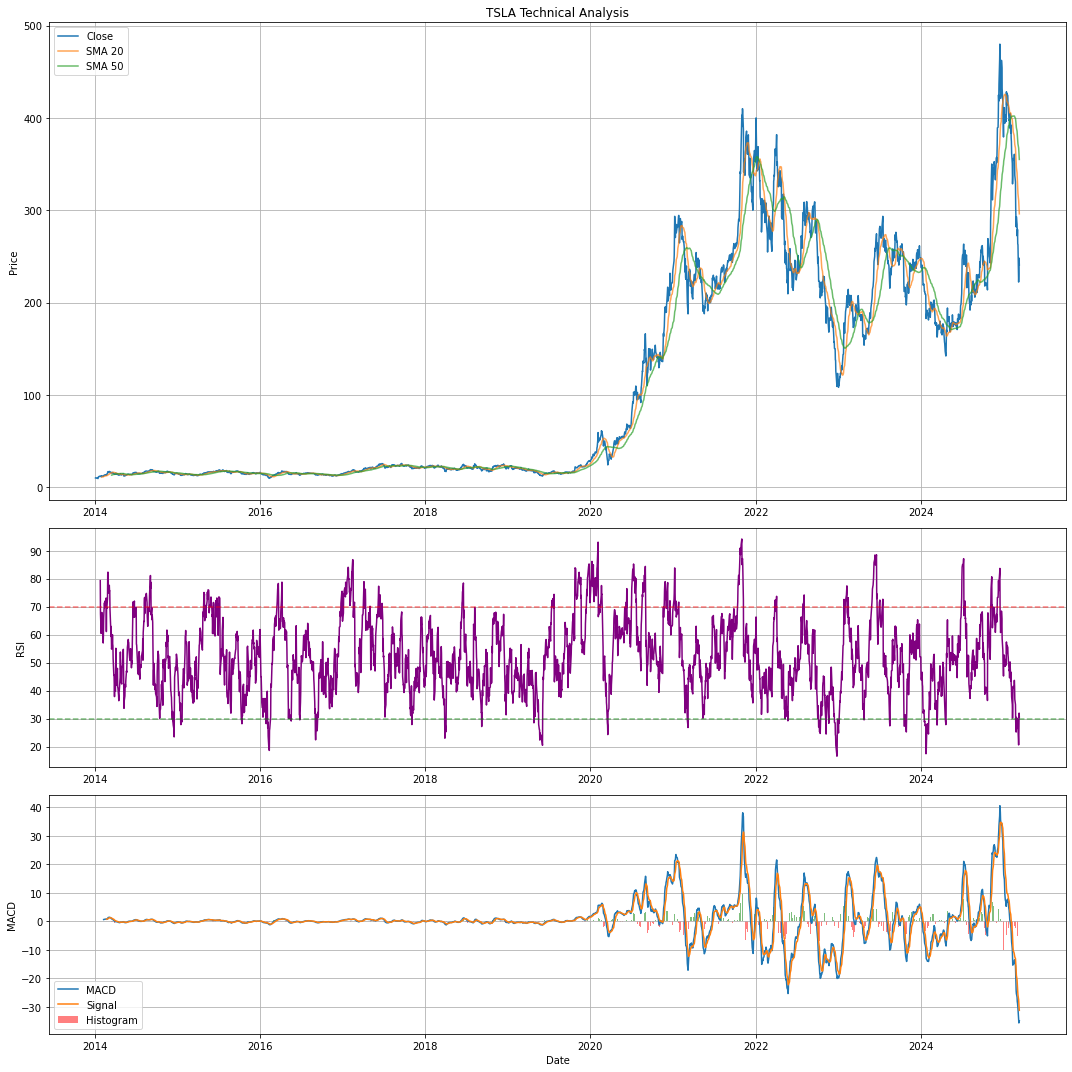

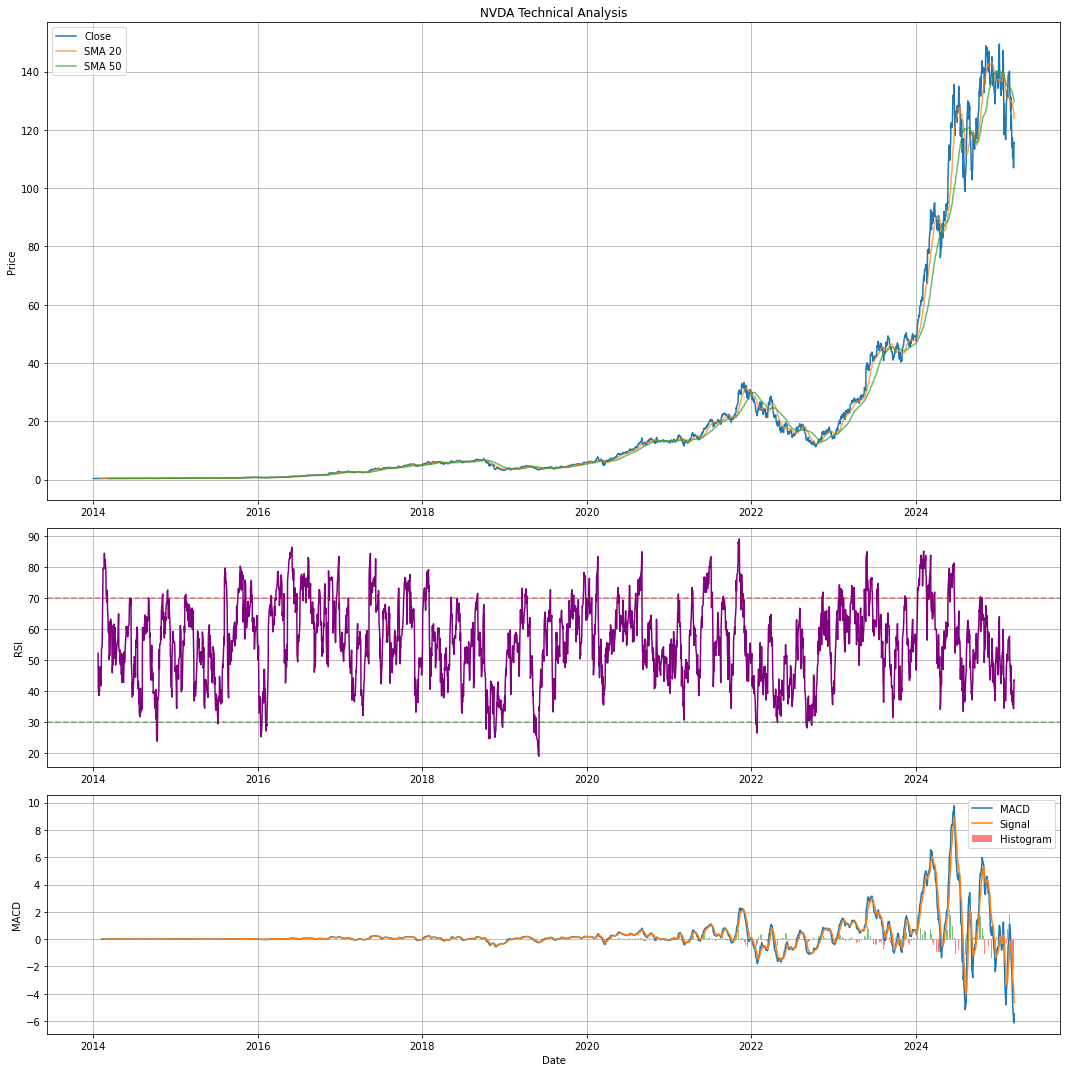

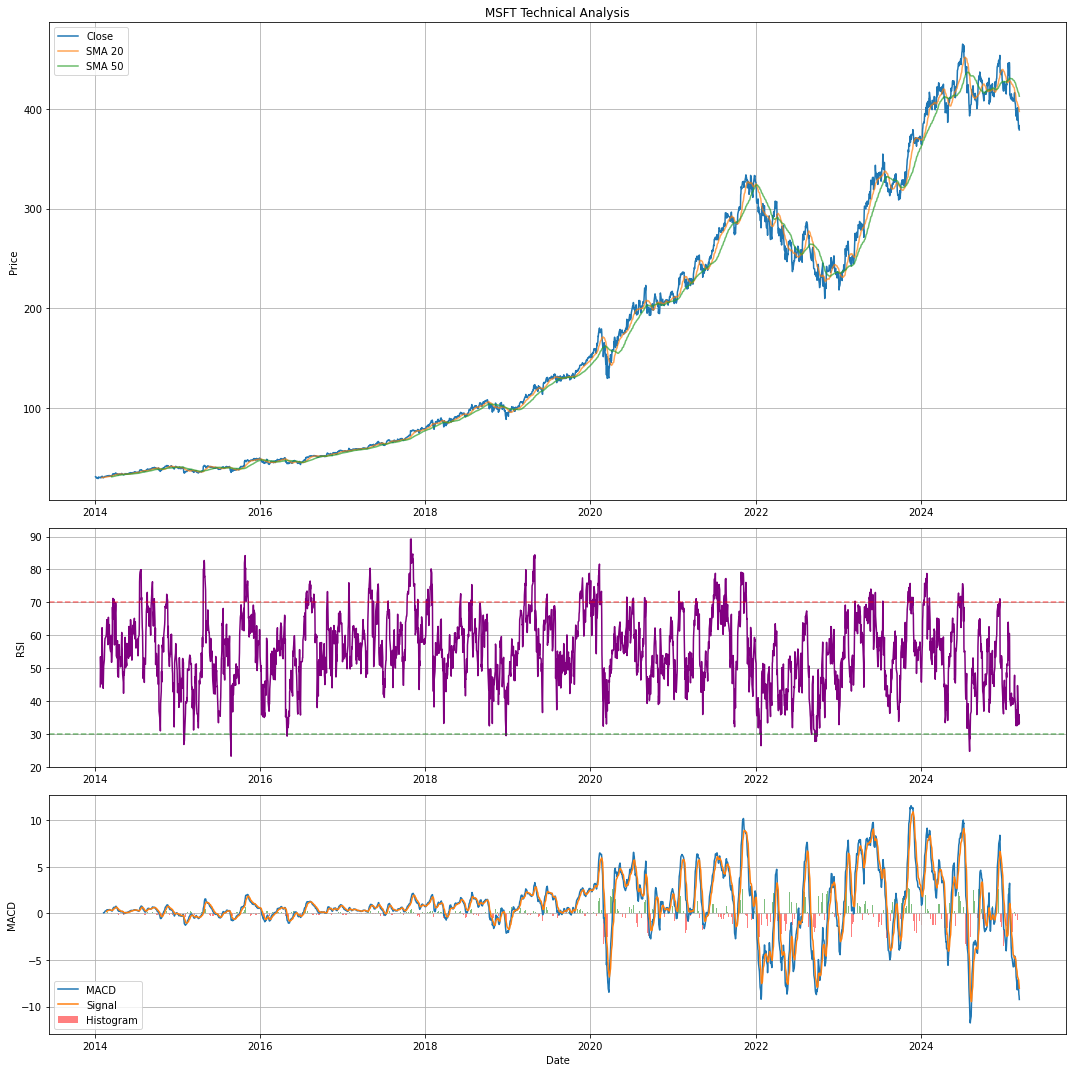

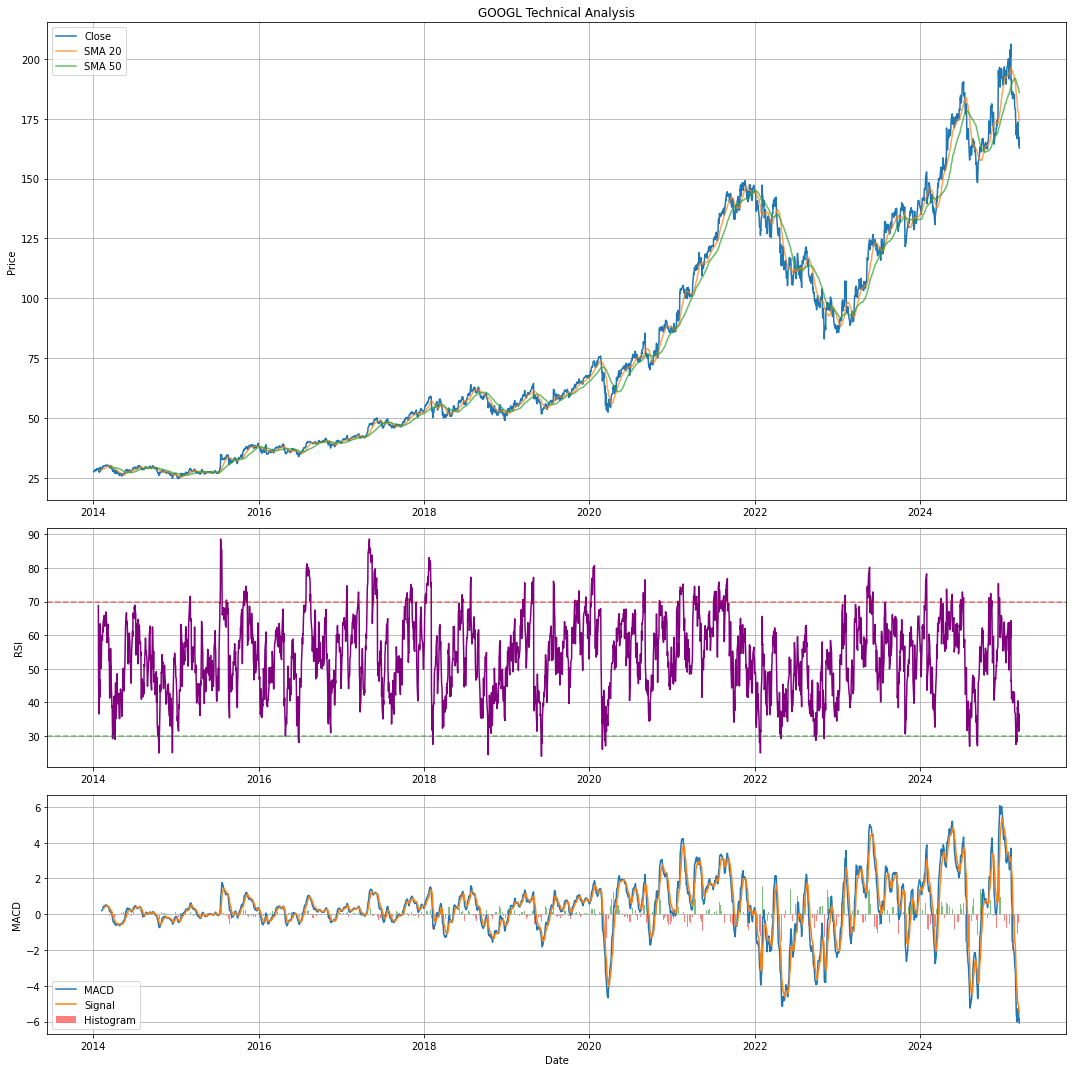

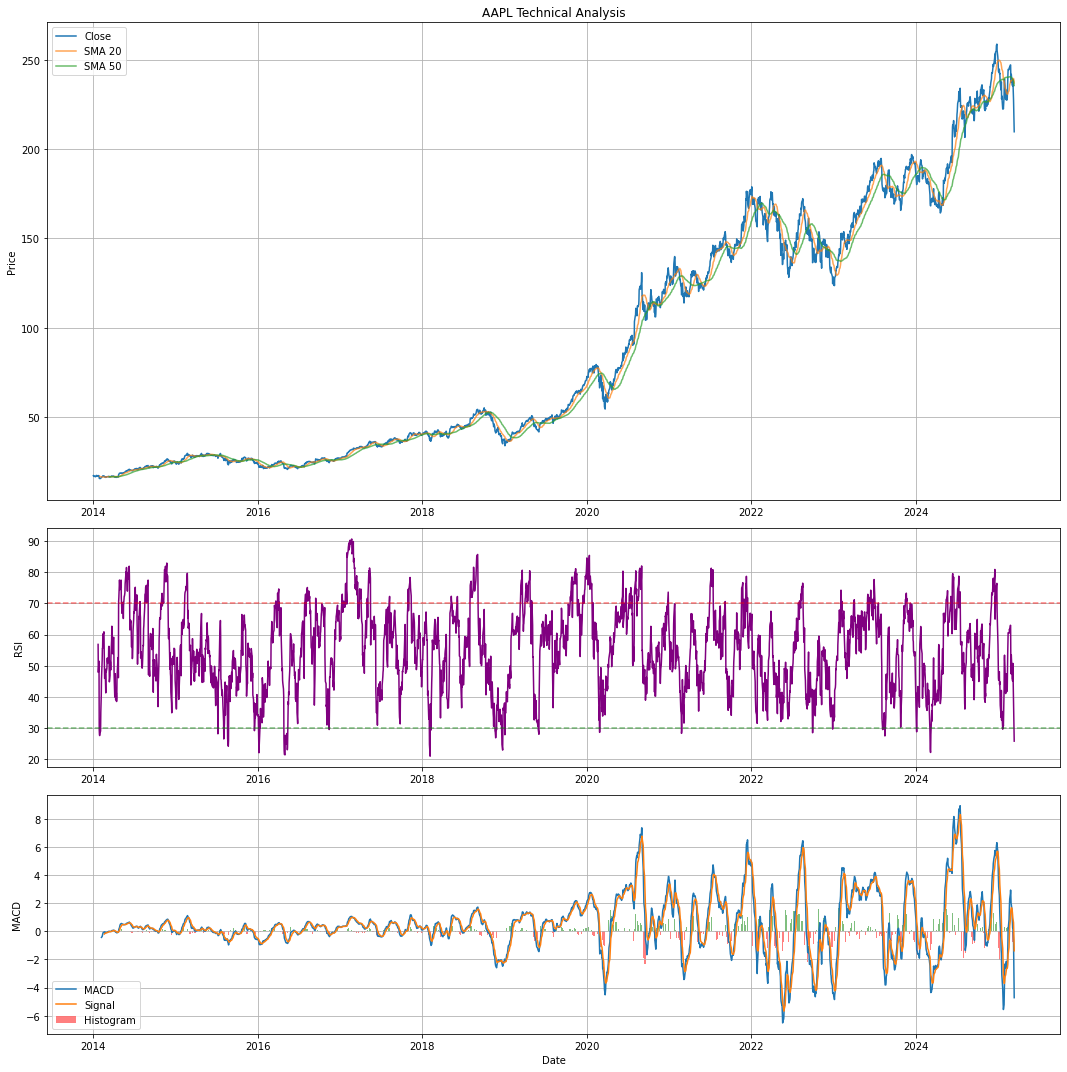

In [8]:
import pandas_ta as ta
import matplotlib.gridspec as gridspec

def plot_with_multiple_indicators(data, symbol):
    # Filter and prepare data
    symbol_data = data[data['symbol'] == symbol].copy()
    symbol_data['trade_date'] = pd.to_datetime(symbol_data['trade_date'])
    symbol_data = symbol_data.sort_values('trade_date')
    
    # Calculate indicators
    symbol_data['rsi'] = ta.rsi(symbol_data['close'], length=14)
    symbol_data['sma_20'] = ta.sma(symbol_data['close'], length=20)
    symbol_data['sma_50'] = ta.sma(symbol_data['close'], length=50)
    symbol_data['macd'] = ta.macd(symbol_data['close'])['MACD_12_26_9']
    symbol_data['macd_signal'] = ta.macd(symbol_data['close'])['MACDs_12_26_9']
    symbol_data['macd_hist'] = ta.macd(symbol_data['close'])['MACDh_12_26_9']
    
    # Create plot with 3 subplots
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    # Price and MAs
    ax1 = plt.subplot(gs[0])
    ax1.plot(symbol_data['trade_date'], symbol_data['close'], label='Close')
    ax1.plot(symbol_data['trade_date'], symbol_data['sma_20'], label='SMA 20', alpha=0.7)
    ax1.plot(symbol_data['trade_date'], symbol_data['sma_50'], label='SMA 50', alpha=0.7)
    ax1.set_title(f'{symbol} Technical Analysis')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    ax1.legend()
    
    # RSI
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(symbol_data['trade_date'], symbol_data['rsi'], color='purple')
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')
    ax2.axhline(30, linestyle='--', alpha=0.5, color='green')
    ax2.set_ylabel('RSI')
    ax2.grid(True)
    
    # MACD
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax3.plot(symbol_data['trade_date'], symbol_data['macd'], label='MACD')
    ax3.plot(symbol_data['trade_date'], symbol_data['macd_signal'], label='Signal')
    ax3.bar(symbol_data['trade_date'], symbol_data['macd_hist'], label='Histogram', 
            color=['green' if x > 0 else 'red' for x in symbol_data['macd_hist']], alpha=0.5)
    ax3.set_ylabel('MACD')
    ax3.set_xlabel('Date')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

    return symbol_data

# Apply to all symbols
technical_indicators_included = []

for symbol in sample_pd['symbol'].unique():
    symbol_data = plot_with_multiple_indicators(sample_pd, symbol)
    technical_indicators_included.append(symbol_data)